In [1]:
import numpy as np
import sys
import empymod

sys.path.append('../')

from emulatte.model import earth
from emulatte.source.loop import HCL

In [2]:
def pos(data):
    """Return positive data; set negative data to NaN."""
    return np.array([x if x > 0 else np.nan for x in data])


def neg(data):
    """Return -negative data; set positive data to NaN."""
    return np.array([-x if x < 0 else np.nan for x in data])

In [3]:
%%time
src = [0,0,0]
rec = [0,0,0]
thicks = []
res = [100]
freq = np.logspace(-1, 6, 601)
model = earth.QuasiStaticEM1D(thicks)
vmd = HCL(1, 50)
# ここでFDTD, waveformを決める
# ontime > 0 : step-on, = 0 : impluse, < 0 : step-off, array-like :  arbitorary_wave, None : FD
# ontimeの設定はloopとlineのみ

model.set_params(res)
model.set_source(vmd, src)
# 今後のことを考えて、デジタルフィルタ（Hankel, Fourier）は外から適用できるように「も」する
model.set_filter(hankel_filter='key201')
EMF = model.field("H", "z", rec, freq)
#emulatte

CPU times: user 55.3 ms, sys: 32.7 ms, total: 88 ms
Wall time: 87.5 ms


In [4]:
%%time
# Survey parameters
radius = 50
area = radius**2*np.pi
freq = np.logspace(-1, 6, 601)
src = [radius, 0, 0, 90, 0]
rec = [0, 0, 0, 0, 90]
depth = 0
res = [2e14, 100]
strength = area/(radius/2)
mrec = True
ep = [0,0]

# Computation
inp = {'src': src, 'rec': rec, 'depth': depth, 'res': res,
       'freqtime': freq, 'strength': strength, 'mrec': mrec,
       'verb': 1, 'epermH':ep}
fhz_num = empymod.bipole(**inp)
#empymod

CPU times: user 528 ms, sys: 238 ms, total: 766 ms
Wall time: 163 ms


In [5]:
# 解析解
radius = 50 #Coil radius

from scipy.constants import mu_0 #真空の透磁率

def hz(f, res, r):
    """
    return equation 4.191, Ward and Hohmann, 1988.as_integer_ratio

    Parametars
    ----------
    f : freqency
        freqency(Hz)
    res : float
        Halfspace resistivity(Ohm-m)
    r : float
        Coil-radius(m)
    
    Returns
    -------
    hz
    """
    current = 1
    omega = 2*np.pi*f
    k = np.sqrt((-1j*mu_0*omega)/res)

    hz = 3 - (3 + 3*1j*k*r - k**2*r**2) *np.exp(-1j*k*r)
    hz *= current / (k**2*r**3)

    return hz

f = np.logspace(-1,6,601)
hz_ana = hz(f, 100, 50)

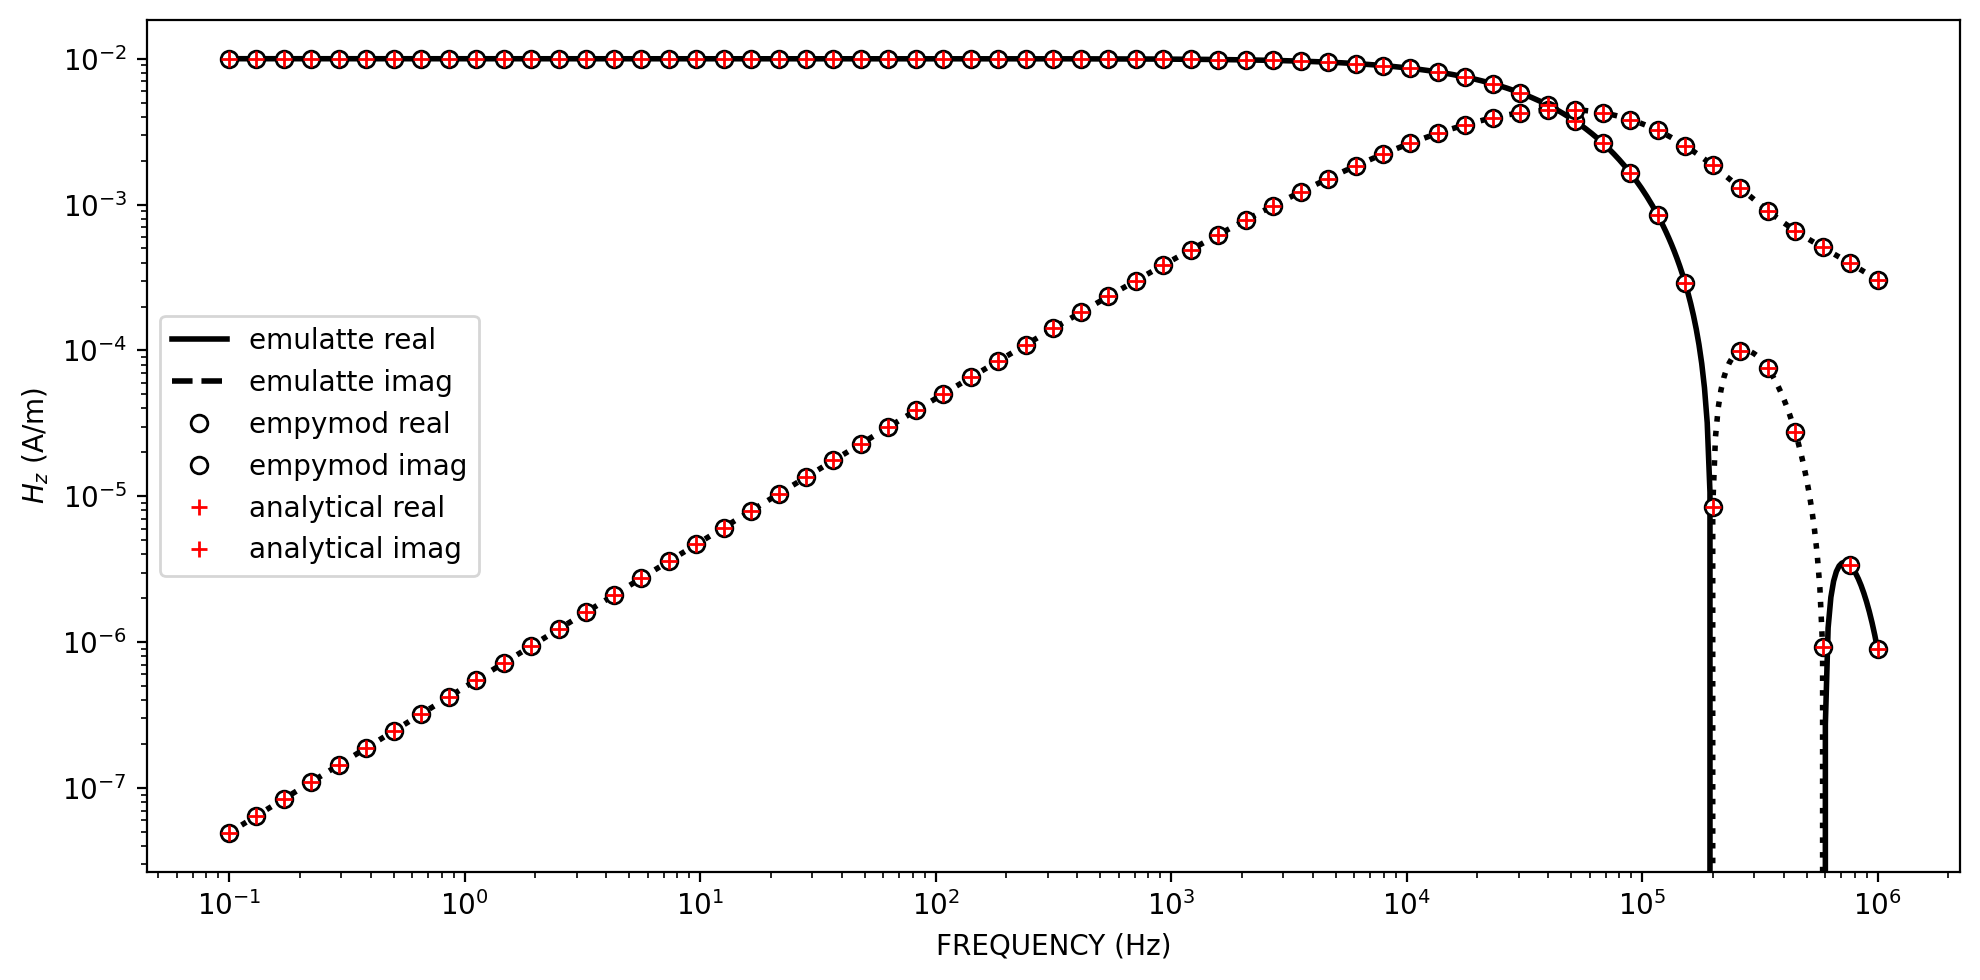

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,5), facecolor='w', dpi=200)
ax = fig.add_subplot(111)
ax.plot(freq, EMF.real, "k-", label='emulatte real', linewidth=2)
ax.plot(freq, -EMF.real, "k:", linewidth=2)
ax.plot(freq, EMF.imag, "k--", label='emulatte imag', linewidth=2)
ax.plot(freq, -EMF.imag, "k:", linewidth=2)
ax.plot(freq[::10], pos(fhz_num.real)[::10], marker="o", linewidth=0, c='k', markerfacecolor='w',label='empymod real')
ax.plot(freq[::10], neg(fhz_num.real)[::10], marker="o", linewidth=0, c='k', markerfacecolor='w')

ax.plot(freq[::10], pos(fhz_num.imag)[::10], marker="o", linewidth=0, c='k', markerfacecolor='w', label='empymod imag')
ax.plot(freq[::10], neg(fhz_num.imag)[::10], marker="o", linewidth=0, c='k', markerfacecolor='w')

ax.plot(freq[::10], pos(hz_ana.real)[::10], marker="+", linewidth=0, c='r', label='analytical real')
ax.plot(freq[::10], neg(hz_ana.real)[::10], marker="+", linewidth=0, c='r')

ax.plot(freq[::10], pos(hz_ana.imag)[::10], marker="+", linewidth=0, c='r', label='analytical imag')
ax.plot(freq[::10], neg(hz_ana.imag)[::10], marker="+", linewidth=0, c='r')
ax.set_xscale('log')
ax.set_yscale('log')
#ax.xlim([1e-1, 1e5])
#ax.ylim([1e-12, 1e-10])
ax.set_xlabel('FREQUENCY (Hz)')
ax.set_ylabel('$H_z$ (A/m)')
ax.legend()

plt.tight_layout()

plt.show()

In [7]:
#%%timeit
src = [0,0,0]
rec = [0,0,0]
thicks = []
res = [100]
time = np.logspace(-10, 0, 301)
model = earth.QuasiStaticEM1D(thicks)
loop = HCL(1, 50, ontime=-1)
# ここでFDTD, waveformを決める
# ontime > 0 : step-on, = 0 : impluse, < 0 : step-off, array-like :  arbitorary_wave, None : FD
# ontimeの設定はloopとlineのみ

model.set_params(res)
model.set_source(loop, src)
# 今後のことを考えて、デジタルフィルタ（Hankel, Fourier）は外から適用できるように「も」する
model.set_filter(hankel_filter='key201')
EMF = model.field("H", "z", rec, time)
EMFdt = model.field("H", "z", rec, time, time_diff=True)
#emulatte

In [8]:
# Survey parameters
radius = 50
area = radius**2*np.pi
time = np.logspace(-10, 0, 301)
src = [radius, 0, 0, 90, 0]
rec = [0, 0, 0, 0, 90]
depth = 0
res = [2e14, 100]
strength = area/(radius/2)
mrec = True
eperm = [0, 0]

# Computation
inp = {'src': src, 'rec': rec, 'depth': depth, 'res': res,
       'freqtime': time, 'strength': strength, 'mrec': mrec,
       'epermH': eperm, 'verb': 1}

hz_num = empymod.bipole(signal=-1, **inp)
dhz_num = empymod.bipole(signal=0, **inp)

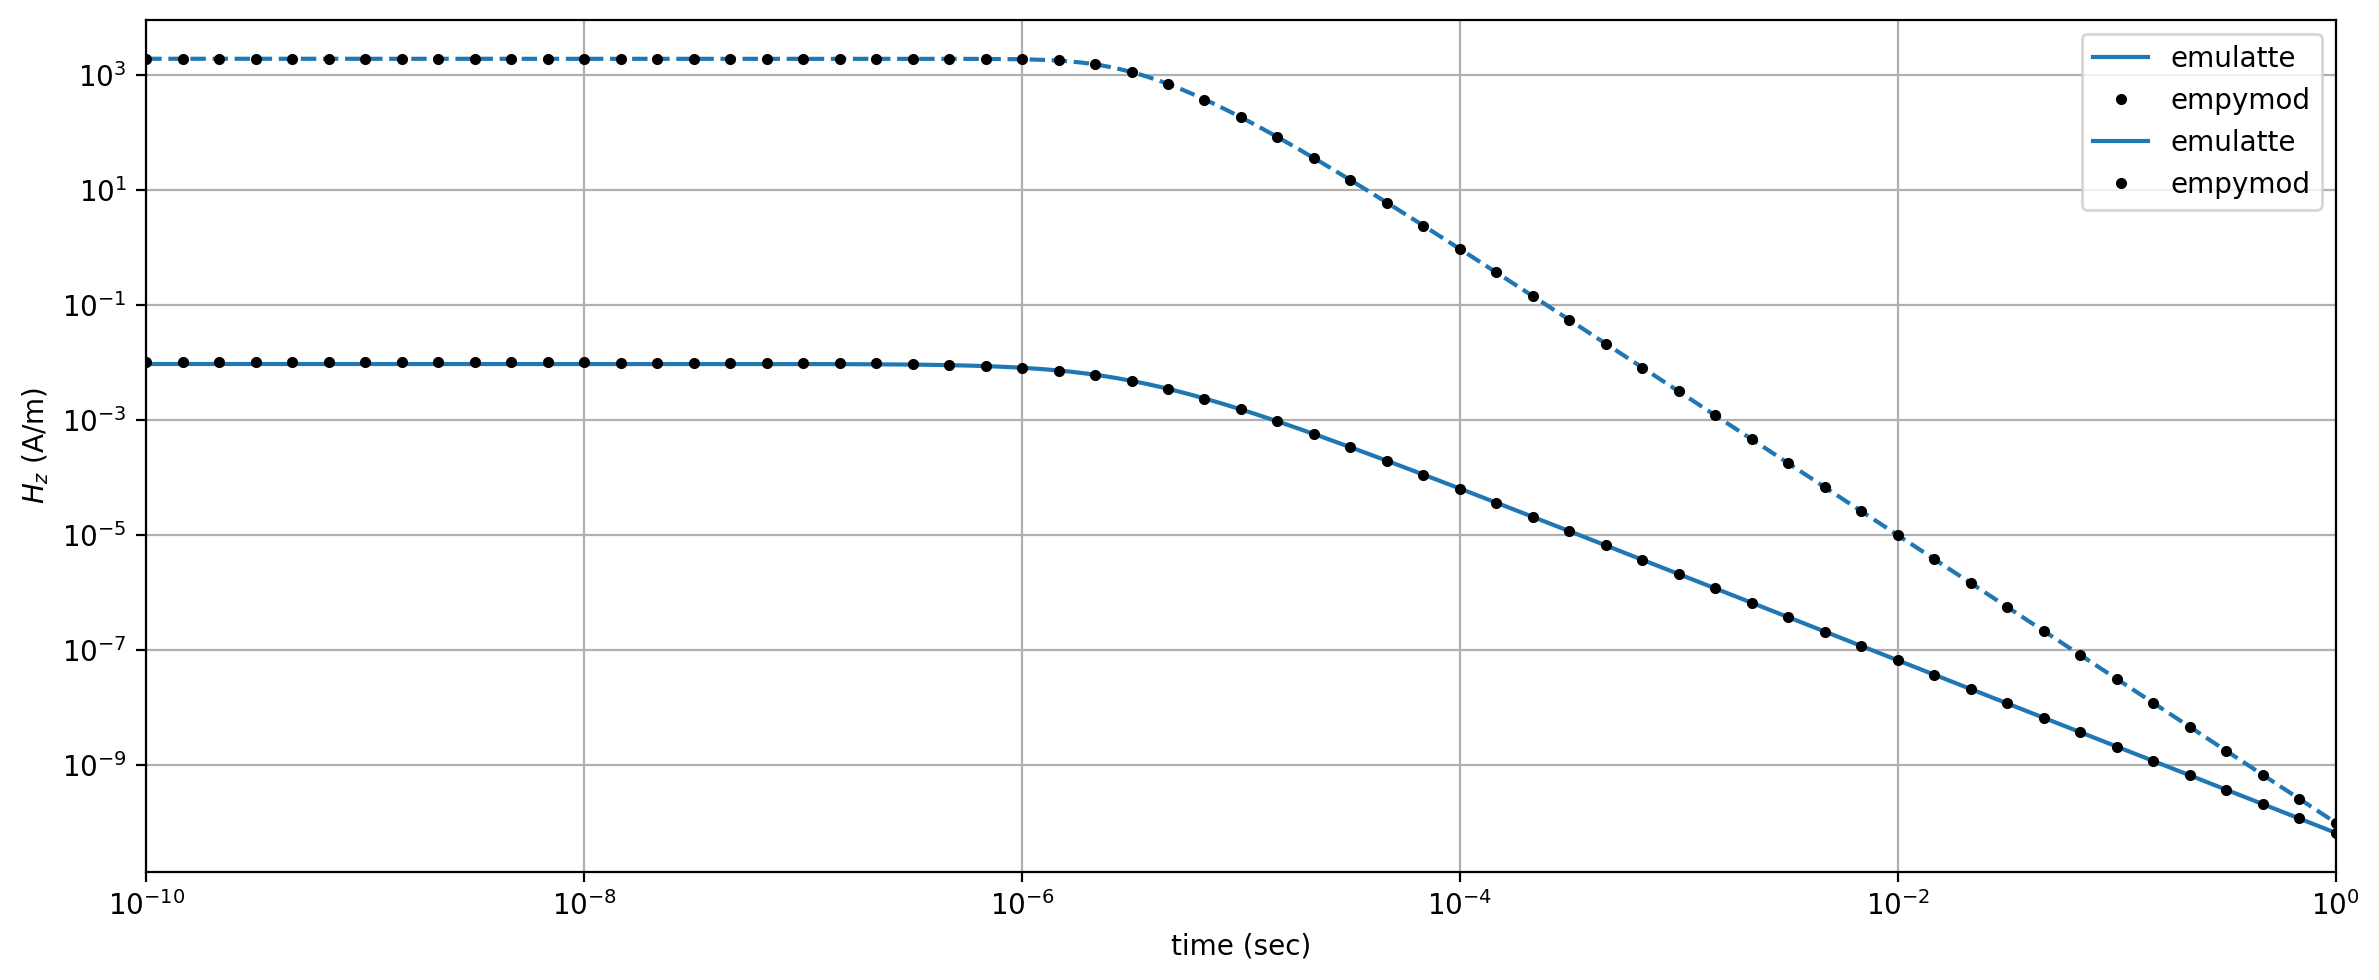

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,5), facecolor='w', dpi=200)
ax = fig.add_subplot(111)
ax.plot(time, EMF, "C0-", label='emulatte')
ax.plot(time, -EMF, "C0--")
ax.plot(time[::5], pos(hz_num)[::5], marker=".", linewidth=0, c='k', label='empymod')
ax.plot(time[::5], neg(hz_num)[::5], marker=".", linewidth=0, c='k')

ax.plot(time, EMFdt, "C0-", label='emulatte')
ax.plot(time, -EMFdt, "C0--")
ax.plot(time[::5], pos(dhz_num)[::5], marker=".", linewidth=0, c='k', label='empymod')
ax.plot(time[::5], neg(dhz_num)[::5], marker=".", linewidth=0, c='k')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([1e-10, 1e0])
#ax.ylim([1e-12, 1e-6])
ax.set_xlabel('time (sec)')
ax.set_ylabel('$H_z$ (A/m)')
ax.legend()
ax.grid()
plt.tight_layout()

plt.show()

In [10]:
x = np.arange(3)
s, t, u = x
s

0